# Installation

Installing the package is trivial as it is registered as a Julia package.

In [1]:
using Pkg
Pkg.add("ApproximateComputations")
Pkg.update()

 Resolving package versions...
  Updating `C:\Users\Tim\.julia\environments\v1.0\Project.toml`
 [no changes]
  Updating `C:\Users\Tim\.julia\environments\v1.0\Manifest.toml`
 [no changes]
  Updating registry at `C:\Users\Tim\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `C:\Users\Tim\.julia\environments\v1.0\Project.toml`
 [no changes]
  Updating `C:\Users\Tim\.julia\environments\v1.0\Manifest.toml`
 [no changes]


To include the library in our project we add it with `using`

In [2]:
using ApproximateComputations

# Approximation Type

The `Approximation` type is a wrapper parent type to be used to enclose data which has been returned
from a non-accurate source. This type can be extended to enclose extra information for debugging or
improving a program by allowing more complex functional behaviour based on type and level of
approximation

Constructing an `Approximation` is trival

In [3]:
param = 5.0
approx_param = Approximation(param)

ApproximateComputations.Approximation{Float64}(5.0)

The value stored in `approx_param` is the same as param, it is simply wrapped to allow for specialised
behaviour. To extract the value and check this we use `Get(x)`

In [4]:
contained_value = Get(approx_param)

5.0

# Approximate Fit Functions

1) Generate new functions which approximate 'sin' in the range 0.001 to pi/2
with 5000 samples set with the `sampleCount` option and a request for a table of the results with
the `retDataFrame` option.

In [5]:
using ApproximateComputations
newFunctionsAndInformation, tableOfResults = GenerateAllApproximationFunctions(sin, 0.001, 1.57, sampleCount=5000, retDataFrame=true);

When we display the results you will see the different precision, order and methods of generation.
By default only a limited set are used. If you look into the documentation you will see the flags
for different types of curve generation.

In [6]:
tableOfResults

,Name,Precision,FitType,Order,abserror,mean,median,benchmark,range
,Any,Any,String,Int64,Float64,Float64,Float64,Any,Tuple…
1,sin,Float32,Source,0,0.0,0.0,0.0,Trial(19.692 μs),"(0.001, 1.57)"
2,sin,Float64,Source,0,0.0,0.0,0.0,Trial(22.974 μs),"(0.001, 1.57)"
3,sin,Float32,PolyLet,7,0.000198884,3.97767e-8,2.98023e-8,Trial(6.872 μs),"(0.001, 1.57)"
4,sin,Float32,PolyLet,9,0.000154257,3.08515e-8,1.49012e-8,Trial(8.752 μs),"(0.001, 1.57)"
5,sin,Float32,PolyLet,11,0.000150217,3.00433e-8,0.0,Trial(10.666 μs),"(0.001, 1.57)"
6,sin,Float32,PolyLet,13,0.000138929,2.77858e-8,0.0,Trial(31.180 μs),"(0.001, 1.57)"
7,sin,Float32,PolyLet,15,0.000145605,2.9121e-8,0.0,Trial(45.948 μs),"(0.001, 1.57)"
8,sin,Float32,PolyLet,17,0.000152519,3.05038e-8,0.0,Trial(54.974 μs),"(0.001, 1.57)"
9,sin,Float32,PolyLet,19,0.000180086,3.60172e-8,1.49012e-8,Trial(66.051 μs),"(0.001, 1.57)"


2) Filter the generated functions to select the fastest executing function within our error constraint:

In [7]:
a = GetFastestAcceptable(newFunctionsAndInformation, meanErrorLimit=0.00000001)
println(GetFunctionName(a))  # -> returns sin_PolyLet9_Float64bit

Selecting Function with minimum time...
Current Best:sin_PolyLet9_Float64bit
sin_PolyLet9_Float64bit


3) Store the function for use:

In [8]:
approxsin = a.generatedFunction

#30 (generic function with 1 method)

4) Compare to accurate function:

In [9]:
approxResult = approxsin(1.0) # -> Approximation{Float64}(0.8414709848311571)
realResult = sin(1.0)   # -> {Float64} (0.8414709848078965)

0.8414709848078965

You will notice that the returned type of the generated function is of the `Approximation{T}` type.
this is to ensure that any use of these functions in an application is with explicit understanding
of the programmer when they extract the value to put it back into "non-approximate"-space.

# Approximate Memoisation
In this package we provide wrapper functions to allow the implementation of approximate memoisation
using either trending batched memoisation or approximate hashing memoisation

Memoisation is a common technique to store the return the values of an expensive
function so that multiple calls do not result in multiple expensive runs of the function.
Memoisation can be ineffecient for numerical applications with slight variations of input
where each input will result a different value being saved even when they are nearly identical.
In an application which is error resilient this is wasted memory as a single value could be
stored for all inputs which are close or result in a similar answer.

As most memoisation is based on a hashtable we are able to construct an approximate memoisation
by allowing for the custom of custom hash functions which result in clashes when any two inputs
are similar enough to be within our error threshold.

With this setup, a hash function which causes a clash for any input values in 0.05 unit steps
can be used to quantise the memoisation and therefore allow for arbitrary precision. A more
complex hash function that allows for mapping based on the first differential of the function
being memoised can give scaled memoisation boundaries based on the maximum value change across
an input range - allowing for optimal storage within your acceptable error range.

To do the simple form of this with our tools we define our hash function and storage object:

In [10]:
sinhash(fn, val) = hash(val)
memoDict = Dict()

Dict{Any,Any} with 0 entries

Then we call the custom hash memoisation function with our targetfunction, storage object and hash
function followed by our inputs to the function.

In [11]:
println(ApproximateHashingMemoise(sin, memoDict, sinhash, 0.4))
println(ApproximateHashingMemoise(sin, memoDict, sinhash, 0.1))

0.3894183423086505
0.09983341664682815


The returned value of the function will either be the actual value of calling that function with
the inputs, or if a value is found in the storage object for the hash of the function and input
then the stored value will be returned. Nice and simple!

The weakness of this type of quantised memoisation is that the first value passed to it for any
given quantisation range will represent the whole range. In some cases where there is a non-uniform
access pattern for each quantisation range a value that is outside the commonly accessed part might
be less representative than others.

To combat this problem we can also use a trending memoisation approach. In this approach every
time a quantised range is accessed the result is added to a record and once the requisite number
of samples has been taken the returned value when a hit is found is the average of all the results
for that quantisation range.

The call to do this is very similiar with the addition of a `samplecount` input variable and we use
a more complex storage object to enable the counting of samples for each element. In the demo below
we use a sample count of `3`:

In [12]:
trendingArray = []
for i in 1:5000
   push!(trendingArray,[0,0.0,0.0])
end

trendingsinhash(fn, val) = 1+Int64.(round(val*10.0))

println(TrendingMemoisation(sin, trendingsinhash, trendingArray, 3, 0.5)  == 0.479425538604203)
println(TrendingMemoisation(sin, trendingsinhash, trendingArray, 3, 0.55) == 0.5226872289306592)
println(TrendingMemoisation(sin, trendingsinhash, trendingArray, 3, 0.51) == 0.48817724688290753)
println(TrendingMemoisation(sin, trendingsinhash, trendingArray, 3, 0.59) == 0.5563610229127838)
println(TrendingMemoisation(sin, trendingsinhash, trendingArray, 3, 0.59) == 0.5563610229127838)

true
true
true
true
true


# Loop Perforation

Loop perforation is an approximation approach where loops are manipulated to reduce the iteration
count in some way to improve the performance of an application without impacting the final result
beyond a fixed constraint.

This part of our library allows for the targeted replacement of loops parameters to achieve this in
a generic way to arbitrary code.

We perform this optimisation on Julia AST representations. As these cannot in the current release of
Julia be directly extracted from a compiled function we require that the source is directly provided,
like so:

In [13]:
expr =	quote
				function newfunc()
					aa = 0
					for i in 1:10
						aa = aa + 1
					end
					aa
				end
			end

quote
    #= string:2 =#
    function newfunc()
        #= string:3 =#
        aa = 0
        #= string:4 =#
        for i = 1:10
            #= string:5 =#
            aa = aa + 1
        end
        #= string:7 =#
        aa
    end
end

This example is of a simple loop which will increment a variable based on a ranged loop. This example
is being used as it is trivial to test if the loop replacement has been a success.

With our function defined we pass it into the loop perforatation function:

In [14]:
LoopPerforation(expr, UnitRange, ClipFrontAndBack)

The function takes three inputs. The source code that is to be manipulated, the type of loop to
target (in this case a loop which uses a UnitRange, others are supported and can be trivially
extended to match any pattern), and a function which will output the replacement parameters.
The result of calling this function is that the input source code is changed in place.

For our demo here we are passing in the source code, `UnitRange` as we are looking to replace the
`1:10` loop parameter which is a `UnitRange` and the included function `ClipFrontAndBack` which
takes the UnitRange and increments the minimum value and decrements the maximum value, resulting
in the range `2:8`.

Once this has been called and has succeeded we can extract the function for use by evaluating the
Julia Expressions:

In [15]:
eval(expr)

newfunc (generic function with 1 method)

We can test to see if the output is what we expect

In [16]:
println(newfunc() == 8)

true


# AST Generation and Analysis

ASTs in this library are formed through trees of `TreeMember` derived types. A `TreeMember` branch can be either
an `Operator` or a `Variable` - leaves can be any type as they are only inputs into the other derived TreeMember
types.

When working with trees we do not define Operators explicitly - they are output from functions which take `Variables`
as inputs. Like so:

In [17]:
DemoFunc(x) = x + x
DemoTree = DemoFunc(Variable(:x))
println(DemoTree)

ApproximateComputations.Operator(+, ApproximateComputations.Variable[Variable(:x, 1), Variable(:x, 1)], 2, "NoStoredData")


We can view these generated trees in a nicer form by using `printtree` - which also gives contextual information on
the information stored within the `TreeMember` entries in the tree.

In [18]:
printtree(DemoTree)

|Function(+) - (id:2) - StoredData:NoStoredData
|  |Symbol(x) - (id:1)
|  |Symbol(x) - (id:1)




We can also view the tree with less information using `ToString`

In [19]:
println(ToString(DemoTree))

|Function(+)
|~~~|Symbol(x)
|~~~|Symbol(x)




We are able to have trees with constants in them, which are not `TreeMember` types

In [20]:
DemoFunc(x) = x + 1.0
DemoTree = DemoFunc(Variable(:x))
println("Tree with constant:")
println(DemoTree)
printtree(DemoTree)

Tree with constant:
ApproximateComputations.Operator(+, Any[Variable(:x, 3), 1.0], 4, "NoStoredData")
|Function(+) - (id:4) - StoredData:NoStoredData
|  |Symbol(x) - (id:3)
|  |Const Float64(1.0)




In our output, the constant values are labelled. When performing some transforms it is useful to have these contained
within a `Variable` type. To do this we use the function `ReplaceConstantsWithVariables(tree)`

In [21]:
println("Tree with constant changed to a Variable type:")
ReplaceConstantsWithVariables(DemoTree)
printtree(DemoTree)

Tree with constant changed to a Variable type:
|Function(+) - (id:4) - StoredData:NoStoredData
|  |Symbol(x) - (id:3)
|  |Float64(1.0) - (id:5)




This transform does not change how the function can be executed or the result. We can test this by running our tree.
Trees are executed by evaluation using `EmulateTree(t, DictInputs=())`

In [22]:
@show input=1.0
print( "Original Result: ")
println( DemoFunc(input) )
print( "Altered Tree Result: ")
println( EmulateTree(DemoTree, Dict(:x=>input)))

input = 1.0 = 1.0
Original Result: 2.0
Altered Tree Result: 2.0


When emulating a tree we need to pass the inputs in as a dictionary for each symbol, or we can define the symbols
globally using `SetSymbolValue(symbol, value)` and we can clear all set variables with `ClearSymbolDict()`

In [23]:
@show input=2.0
SetSymbolValue(:x, input)
print( "Original Result: ")
println( DemoFunc(input) )
print( "Altered Tree Result: ")
println( EmulateTree(DemoTree) )
ClearSymbolDict()

input = 2.0 = 2.0
Original Result: 3.0
Altered Tree Result: 3.0


Dict{Any,Any} with 0 entries

When we want to create a tree from more complex functions we need to anable the environment to be able to map any
internal function calls to our AST inputs types.

In [24]:
ComplexFunction(x) = sqrt(x)

try
   ComplexTree = ComplexFunction(Variable(:x))
catch
   println("We were unable to create an AST from ComplexFunction as `sqrt` is not defined to take a Variable as an input.")
end

We were unable to create an AST from ComplexFunction as `sqrt` is not defined to take a Variable as an input.


To be able to create the tree we need to detect all the function calls within the submitted function and override them.
In Julia we cannot override a function unless it has been imported. As we cannot import functions when not at the global
scope we have provided the macro `@importall' which will import all functions from a module automatically so that we can
override them with our AST creation types.

In [25]:
using ImportAll
@importall Base

println("Generating override functions: ")
ovr = GetOverrides(ComplexFunction)
eval(GetConstructionFunction())(ovr, verbose=true)
println("Done!")

Generating override functions: 
sqrt - declared with 1 inputs
Done!


With the environment configured we can not generate the tree for `ComplexFunction` without error.

In [26]:
println("We can now generate the tree for ComplexFunction:")
ComplexTree = ComplexFunction(Variable(:x))
printtree(ComplexTree)

We can now generate the tree for ComplexFunction:
|Function(sqrt) - (id:8) - StoredData:NoStoredData
|  |Symbol(x) - (id:7)




Once we are done with global variables we can clear them using `ClearSymbolDict()`

In [27]:
println("Clearing symbol dictionary:")
ClearSymbolDict()

Clearing symbol dictionary:


Dict{Any,Any} with 0 entries

When we generate a tree each node is given a unique ID so that is can be easily targeted.
The current GlobalID index can be retrieved with `GetGlobalID()` and reset with `ResetGlobalID()`

In [28]:
println("Current Global ID index is: $(GetGlobalID())")
ResetGlobalID()
println("Current Global ID index is: $(GetGlobalID())")

Current Global ID index is: 9
Current Global ID index is: 1


To be able to analyse trees we have provided methods to be able to extract information.
We will create an analysis function here to be our test object.

In [29]:
AnalysisFunction(x,y) = sqrt( (10.0 * x) + (5 * y * x * x) )
ovr = GetOverrides(AnalysisFunction)
eval(GetConstructionFunction())(ovr, verbose=true)
AnalysisTree = AnalysisFunction(Variable(:x), Variable(:y))
ReplaceConstantsWithVariables(AnalysisTree)

* - declared with 2 inputs
* - declared with 4 inputs
+ - declared with 2 inputs
sqrt - declared with 1 inputs


First to get all the leaf nodes in the tree:

In [30]:
println("Show the initial state of the tree:")
println(ToString(AnalysisTree))

Show the initial state of the tree:
|Function(sqrt)
|~~~|Function(+)
|~~~|~~~|Function(*)
|~~~|~~~|~~~|Float64(10.0)
|~~~|~~~|~~~|Symbol(x)
|~~~|~~~|Function(*)
|~~~|~~~|~~~|Function(*)
|~~~|~~~|~~~|~~~|Function(*)
|~~~|~~~|~~~|~~~|~~~|Int64(5)
|~~~|~~~|~~~|~~~|~~~|Symbol(y)
|~~~|~~~|~~~|~~~|Symbol(x)
|~~~|~~~|~~~|Symbol(x)




Showing the leaves in our tree:

In [31]:
println("All Leaves:")
println(GetAllLeaves(AnalysisTree))

All Leaves:
Any[Variable(10.0, 10), Variable(:x, 2), Variable(5, 11), Variable(:y, 3)]


Showing the symbols being used in our tree:

In [32]:
println("All Symbols:")
println(GetAllSymbols(AnalysisTree))

All Symbols:
Any[:x, :y]


Getting all the operators in this tree

In [33]:
println("All Operators:")
println(GetOperators(AnalysisTree))

All Operators:
Any[Operator(sqrt, ApproximateComputations.Operator[Operator(+, ApproximateComputations.Operator[Operator(*, Any[Variable(10.0, 10), Variable(:x, 2)], 4, "NoStoredData"), Operator(*, ApproximateComputations.TreeMember[Operator(*, ApproximateComputations.TreeMember[Operator(*, Any[Variable(5, 11), Variable(:y, 3)], 5, "NoStoredData"), Variable(:x, 2)], 6, "NoStoredData"), Variable(:x, 2)], 7, "NoStoredData")], 8, "NoStoredData")], 9, "NoStoredData"), Operator(+, ApproximateComputations.Operator[Operator(*, Any[Variable(10.0, 10), Variable(:x, 2)], 4, "NoStoredData"), Operator(*, ApproximateComputations.TreeMember[Operator(*, ApproximateComputations.TreeMember[Operator(*, Any[Variable(5, 11), Variable(:y, 3)], 5, "NoStoredData"), Variable(:x, 2)], 6, "NoStoredData"), Variable(:x, 2)], 7, "NoStoredData")], 8, "NoStoredData"), Operator(*, Any[Variable(10.0, 10), Variable(:x, 2)], 4, "NoStoredData"), Operator(*, ApproximateComputations.TreeMember[Operator(*, ApproximateComput

We also provide a function to extract just the IDs of each operator.

In [34]:
println("All Operators IDs:")
println(GetOperatorIDs(AnalysisTree))

All Operators IDs:
Any[9, 8, 4, 7, 6, 5]


Get all subtrees:

In [35]:
println("Showing one of the subtrees:")
println(ToString(GetAllTrees(AnalysisTree)[3]))

Showing one of the subtrees:
|Function(*)
|~~~|Float64(10.0)
|~~~|Symbol(x)




We can extract a specific branch by ID

In [36]:
println("Extracting a specific subtree:")
println(ToString(GetSubTree(AnalysisTree, 6)))

Extracting a specific subtree:
|Function(*)
|~~~|Function(*)
|~~~|~~~|Int64(5)
|~~~|~~~|Symbol(y)
|~~~|Symbol(x)




If we want to edit the tree we can do replacement on any node.

Here we will replace the multiply by `5.0` at ID=11 to a multiply by `24.5`

In [37]:
println("Changing the value of Variable with ID=11 from 5.0 to 24.5")
ReplaceSubTree(AnalysisTree, Variable(24.5) ,11)

Changing the value of Variable with ID=11 from 5.0 to 24.5


And here is the result.
We can see that it has replaced the `Variable` with ID 11 with the new `Variable` we created which has the ID 12

In [38]:
println(ToString(AnalysisTree))

|Function(sqrt)
|~~~|Function(+)
|~~~|~~~|Function(*)
|~~~|~~~|~~~|Float64(10.0)
|~~~|~~~|~~~|Symbol(x)
|~~~|~~~|Function(*)
|~~~|~~~|~~~|Function(*)
|~~~|~~~|~~~|~~~|Function(*)
|~~~|~~~|~~~|~~~|~~~|Float64(24.5)
|~~~|~~~|~~~|~~~|~~~|Symbol(y)
|~~~|~~~|~~~|~~~|Symbol(x)
|~~~|~~~|~~~|Symbol(x)




We can also transform any variable into a different type. So lets change the `Variable` we have just inserted from
a Float64 to a Float32

In [39]:
println("Changing the type of Variable with ID=12 from Float64 to Float32")
ReplaceTypeOfSpecifiedVariable(AnalysisTree, 12, Float32)
println(ToString(AnalysisTree))

Changing the type of Variable with ID=12 from Float64 to Float32
|Function(sqrt)
|~~~|Function(+)
|~~~|~~~|Function(*)
|~~~|~~~|~~~|Float64(10.0)
|~~~|~~~|~~~|Symbol(x)
|~~~|~~~|Function(*)
|~~~|~~~|~~~|Function(*)
|~~~|~~~|~~~|~~~|Function(*)
|~~~|~~~|~~~|~~~|~~~|Float32(24.5)
|~~~|~~~|~~~|~~~|~~~|Symbol(y)
|~~~|~~~|~~~|~~~|Symbol(x)
|~~~|~~~|~~~|Symbol(x)




That worked - but what if we wanted to change all `Variable`'s of one type to another? We use
 `ReplaceAllVariablesOfType(tree, targettype, replacementtype)`. This will go through and replace all entries of one type
with another. This step will replace the last Float64 with a Float32 of the same value.

In [40]:
println("Changing the type of all Float64 variables to Float32")
ReplaceAllVariablesOfType(AnalysisTree, Float64, Float32)
println(ToString(AnalysisTree))

Changing the type of all Float64 variables to Float32
|Function(sqrt)
|~~~|Function(+)
|~~~|~~~|Function(*)
|~~~|~~~|~~~|Float32(10.0)
|~~~|~~~|~~~|Symbol(x)
|~~~|~~~|Function(*)
|~~~|~~~|~~~|Function(*)
|~~~|~~~|~~~|~~~|Function(*)
|~~~|~~~|~~~|~~~|~~~|Float32(24.5)
|~~~|~~~|~~~|~~~|~~~|Symbol(y)
|~~~|~~~|~~~|~~~|Symbol(x)
|~~~|~~~|~~~|Symbol(x)




In the above example you may have noticed that the type of the symbol `x` is ambiguous. This is due to it being dependent
on what value you assign to the symbol. If you want it to be a Float32 then pass a Float32 to the function when it is called.

When we have finished making changes to the AST we may want to be able to convert it back to a normal Julia function, we can
do that with `TreeToFunction`

In [41]:
func = TreeToFunction(AnalysisTree, :OutputFunction)
print( "Tree Result: ")
println( EmulateTree(AnalysisTree, Dict(:x=>1.0, :y=>2.0)) )
print( "Generated Function Result: ")
println( func(1.0, 2.0) )
println("Name of function: $(func)")

Tree Result: 7.681145747868608
Generated Function Result: 7.681145747868608
Name of function: ApproximateComputations.OutputFunction


To help in analysing error between similar functions we provide the functions
`TreeComparison` and `PrintTreeComparisonError` to compute the difference in results

To show this we will create an arbitrary function `ErrorTestingFunction` which does a few operations

In [42]:
ErrorTestingFunction(x) = ((100.0/x) * x) + (0.0001 * x) * (10.00004 / x)
HighPrecisionTestingTree = ErrorTestingFunction(Variable(:x))

ApproximateComputations.Operator(+, ApproximateComputations.Operator[Operator(*, ApproximateComputations.TreeMember[Operator(/, Any[100.0, Variable(:x, 13)], 14, "NoStoredData"), Variable(:x, 13)], 15, "NoStoredData"), Operator(*, ApproximateComputations.Operator[Operator(*, Any[0.0001, Variable(:x, 13)], 16, "NoStoredData"), Operator(/, Any[10.0, Variable(:x, 13)], 17, "NoStoredData")], 18, "NoStoredData")], 19, "NoStoredData")

We will then make a copy of it and reduce the precision to inject some error into the function

In [43]:
LowPrecisionTestingTree = deepcopy(HighPrecisionTestingTree)
ReplaceAllVariablesOfType(LowPrecisionTestingTree, Float64, Float32)
printtree(LowPrecisionTestingTree)

|Function(+) - (id:19) - StoredData:NoStoredData
|  |Function(*) - (id:15) - StoredData:NoStoredData
|  |  |Function(/) - (id:14) - StoredData:NoStoredData
|  |  |  |Const Float64(100.0)
|  |  |  |Symbol(x) - (id:13)
|  |  |Symbol(x) - (id:13)
|  |Function(*) - (id:18) - StoredData:NoStoredData
|  |  |Function(*) - (id:16) - StoredData:NoStoredData
|  |  |  |Const Float64(0.0001)
|  |  |  |Symbol(x) - (id:13)
|  |  |Function(/) - (id:17) - StoredData:NoStoredData
|  |  |  |Const Float64(10.00004)
|  |  |  |Symbol(x) - (id:13)




We will then generate some input values between `0.01` and `1.0` to use as inputs of the correct type

In [44]:
HighPrecTestData = collect(0.01:0.001:1.0)
LowPrecTestData = Float32.(HighPrecTestData)

991-element Array{Float32,1}:
 0.01 
 0.011
 0.012
 0.013
 0.014
 0.015
 0.016
 0.017
 0.018
 0.019
 ⋮    
 0.992
 0.993
 0.994
 0.995
 0.996
 0.997
 0.998
 0.999
 1.0  

As testing this function needs to specify which symbol needs to be given a value for input
we need to extend our inputs to include which symbol input value they are representing.

In [45]:
HighPrecisionComparisonInput = []
LowPrecisionComparisonInput  = []
for i in 1:length(HighPrecTestData)
    push!(HighPrecisionComparisonInput,(:x, HighPrecTestData[i]))
    push!(LowPrecisionComparisonInput,(:x, LowPrecTestData[i]))
end

We then pass the high and low precision trees and inputs to `TreeComparison` to get the
error data which we can print with `PrintTreeComparisonError`. This will give the overall
error output of the function and compare the two.

In [46]:
compResults = TreeComparison(HighPrecisionTestingTree, LowPrecisionTestingTree, HighPrecisionComparisonInput, LowPrecisionComparisonInput)
PrintTreeComparisonError(compResults)

Min    Error 0.0
Max    Error 2.842170943040401e-14
Median Error 0.0
Mean   Error 2.9970420135996152e-15


When we have similar tree we want to determine the different in error at each node for each input.
For this we use `GetErrorInTree`. This will output a new tree with the average error at each node stored
and optionally with the `fetchtimeline` flag it will also return an array of the error for each input at
each node.

In [47]:
resultsTree, perinputresults = GetErrorInTree(HighPrecisionTestingTree, LowPrecisionTestingTree, :x, HighPrecTestData, LowPrecTestData, fetchtimeline=true)
printtree(resultsTree)

|Function(+) - (id:19) - StoredData:2.842170943040401e-14
|  |Function(*) - (id:15) - StoredData:2.842170943040401e-14
|  |  |Function(/) - (id:14) - StoredData:0.0003196788729837863
|  |  |  |Const Float64(100.0)
|  |  |  |Symbol(x) - (id:13)
|  |  |Symbol(x) - (id:13)
|  |Function(*) - (id:18) - StoredData:4.336808689942018e-19
|  |  |Function(*) - (id:16) - StoredData:2.956390381526723e-12
|  |  |  |Const Float64(0.0001)
|  |  |  |Symbol(x) - (id:13)
|  |  |Function(/) - (id:17) - StoredData:3.196801515059633e-5
|  |  |  |Const Float64(10.00004)
|  |  |  |Symbol(x) - (id:13)




These errors per node can then be graphed with `PlotASTError` to give a clear idea of where error is introduced into the program for
each input by displaying the error for each input for each subtree.

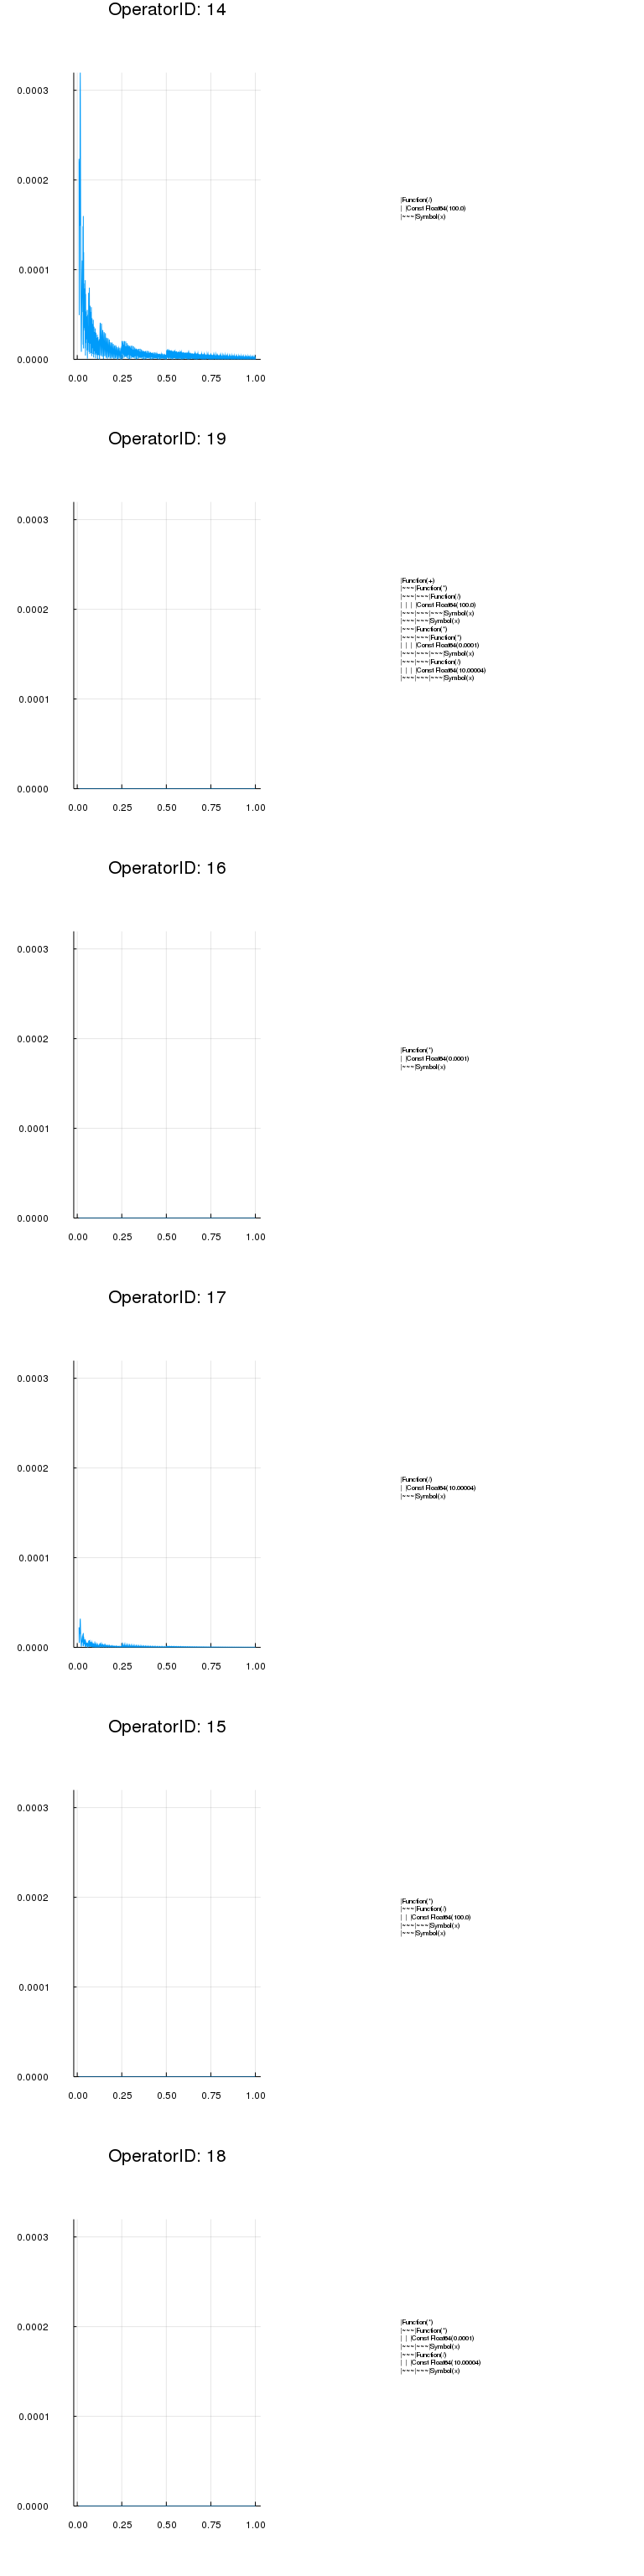

In [48]:
PlotASTError(resultsTree, perinputresults, HighPrecTestData, (768,512))

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*